#WHO Scraping and Information Retrieval

Credit and Pyterrier documentation:
* https://pyterrier.readthedocs.io/en/latest/
* https://github.com/terrier-org/pyterrier/blob/master/examples/notebooks/indexing.ipynb
* https://github.com/terrier-org/pyterrier/blob/master/examples/notebooks/ltr.ipynb

## Installing libraries

In [ ]:
!pip install beautifulsoup4
!pip install top2vec[sentence_encoders]
!pip install top2vec
!pip install python-terrier

!pip install top2vec
!pip install top2vec[sentence_encoders]
!pip install demoji
!pip install emoji
!conda install tbb
!pip install --upgrade tbb

#!pip install gensim==3.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 15.4 MB/s 
     |████████████████████████████████| 88 kB 5.8 MB/s 
     |████████████████████████████████| 5.2 MB 43.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 4.6 MB 29.8 MB/s 
     |████████████████████████████████| 1.1 MB 43.7 MB/s 
     |████████████████████████████████| 511.7 MB 5.5 kB/s 
     |████████████████████████████████| 511.7 MB 4.2 kB/s 
ERROR: Operation cancelled by user
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached top2vec-1.0.27-py3-none-any.whl (25 kB)
  Using cached umap-learn-0.5.3.tar.gz (88 kB)
  Using cached gensim-4.2.0-cp37-

In [ ]:
from top2vec import Top2Vec

#Scraping
import requests
#from selenium import webdriver
from bs4 import BeautifulSoup
import pandas as pd
import re

#language preprocessing
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import pyterrier as pt



from top2vec import Top2Vec

import emoji
import demoji
demoji.download_codes()

import json
import pandas as pd
import numpy as np
import regex as re
import pickle

import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#from gensim.models.wrappers import LdaMallet
#from gensim.models import LdaModel
#from gensim.models.coherencemodel import CoherenceModel

#import pyLDAvis
#from pyLDAvis.gensim_models import prepare

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.


In [ ]:
#Connnect to google drive 
from google.colab import drive
drive.mount('/content/gdrive')

#Collect WHO data

## collect main categories

In [ ]:
page = requests.get('https://www.who.int/emergencies/diseases/novel-coronavirus-2019/question-and-answers-hub')
soup = BeautifulSoup(page.content, "html.parser")

In [ ]:
def scrape_QA_topics(soup):
  """ fetches title and links/href of all of the main topics of WHO Q&A site """

  # create empty lists to collect data
  topics, links = [], []

  # collect all categories
  for a in soup.findAll('a', href=True, attrs={'class':'sf-list-vertical__item'}):
    
    # collect titles
    name = a.find(attrs = {'class':'trimmed'})
    topics.append(name.text)
    
    # collect links
    links.append(a['href'])

  return topics, links

topics_list, links_list = scrape_QA_topics(soup)

In [ ]:
print(len(topics_list))
print(len(links_list))

56
56


## collect answers to questions in each category

In [ ]:
def scrape_QA_answers(beautiful_soup, links, topics):
  """ reads content from each of the given main topic links and create a dictionary 
  of main topics, each with a nested dictionary of question and answer """

  category_dict = {}

  #
  for i in range(len(links)):
    page = requests.get('https://www.who.int'+links[i])
    soup = BeautifulSoup(page.content, "html.parser")

    #create a dicionary with answers and questions
    questions, answers = [], []

    #collect all categories
    for a in soup.findAll('a',href=True, attrs={'class':'sf-accordion__link'}):
      #collect subtitles
      title=a.find(attrs={'itemprop':'name'})
      questions.append(title.text)

    for a in soup.findAll('div',href=False, attrs={'class':'sf-accordion__content'}):
      answer=a.find(attrs={'itemprop':'text'})
      answers.append(answer.text)

    subcategory_dict = dict(zip(questions, answers))

    
    category_dict[topics[i]] = subcategory_dict

  return category_dict

category_dict = scrape_QA_answers(soup, links_list, topics_list)

In [ ]:
#category_dict

In [ ]:
def QA_to_dataframe(nested_dict):
  """ produces a dataframe from the given nested dict, with columns containing, 
  main topics, questions and answers """
  df = None

  for k, v in nested_dict.items():
    for k_sub, v_sub in v.items():
      row = [k, k_sub, v_sub]

      if df is None:
        df = pd.DataFrame([row], columns = ["Category", "Question", "Answer"])
      else:
        df = df.append(pd.DataFrame([row], columns = ["Category", "Question", "Answer"]))

  df.reset_index(inplace=True, drop=True)
  
  return df


def initial_clean_QA(df):
  """performs initial cleaning of questions of answers to clean text that can be 
  used as output for user after topic matching """

  regex_list, replace_list = [r'\n'], ['']
  df = df.replace(regex_list, replace_list, regex=True)

  df_cleaned = df.copy()
  df_cleaned.Question, df_cleaned.Answer = df.Question.str.lower(), df.Answer.str.lower()

  return df, df_cleaned


def combine_QA(df):
  """ Combines text from questions and answers into a single column """

  df2 = df.copy()
  df2['QA_combined'] = df2["Question"] + df2["Answer"]
  df2.drop(['Question', 'Answer'], axis=1, inplace=True)

  return df2


def preprocess_QA(df):
  ''' remove frequent words without contextual meaning and word variations'''

  regex_list, replace_list = [r'covid-19', r'\d+\.?\d+?', '[^A-Za-z0-9\s]+', r' +'], ['', ' ', ' ', ' ']
  df.QA_combined = df.QA_combined.replace(regex_list, replace_list, regex=True)

  #lemmatization
  lemmatizer = WordNetLemmatizer()
  df.QA_combined = df.QA_combined.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

  #remove stop-words
  stop_words = stopwords.words('english')
  df.QA_combined = df.QA_combined.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

  return df


df = QA_to_dataframe(category_dict)
df, df_cleaned = initial_clean_QA(df)
df_combined = combine_QA(df_cleaned)
df_preprocessed = preprocess_QA(df_combined)
display(df), display(df_cleaned), display(df_preprocessed)

,Category,Question,Answer
0,Coronavirus disease (COVID-19),What is COVID-19?,COVID-19 is the disease caused by a new corona...
1,Coronavirus disease (COVID-19),What are the symptoms of COVID-19?,The most common symptoms of COVID-19 areFeverD...
2,Coronavirus disease (COVID-19),What happens to people who get COVID-19?,"Among those who develop symptoms, most (about ..."
3,Coronavirus disease (COVID-19),Who is most at risk of severe illness from COV...,"People aged 60 years and over, and those with ..."
4,Coronavirus disease (COVID-19),Are there long-term effects of COVID-19?,"Some people who have had COVID-19, whether the..."
...,...,...,...
521,"Pandemic prevention, preparedness and response...",The proposed accord may focus on “pandemics”; ...,It could be anticipated that a new accord coul...
522,"Pandemic prevention, preparedness and response...",How can citizens and the general public keep i...,"The Intergovernmental Negotiating Body is, per..."
523,"Pandemic prevention, preparedness and response...",How much authority could an accord have over s...,The working draft presented based on progress ...
524,"Pandemic prevention, preparedness and response...",What could happen if countries that join or pa...,It would be up to Member States to decide if a...


,Category,Question,Answer
0,Coronavirus disease (COVID-19),what is covid-19?,covid-19 is the disease caused by a new corona...
1,Coronavirus disease (COVID-19),what are the symptoms of covid-19?,the most common symptoms of covid-19 arefeverd...
2,Coronavirus disease (COVID-19),what happens to people who get covid-19?,"among those who develop symptoms, most (about ..."
3,Coronavirus disease (COVID-19),who is most at risk of severe illness from cov...,"people aged 60 years and over, and those with ..."
4,Coronavirus disease (COVID-19),are there long-term effects of covid-19?,"some people who have had covid-19, whether the..."
...,...,...,...
521,"Pandemic prevention, preparedness and response...",the proposed accord may focus on “pandemics”; ...,it could be anticipated that a new accord coul...
522,"Pandemic prevention, preparedness and response...",how can citizens and the general public keep i...,"the intergovernmental negotiating body is, per..."
523,"Pandemic prevention, preparedness and response...",how much authority could an accord have over s...,the working draft presented based on progress ...
524,"Pandemic prevention, preparedness and response...",what could happen if countries that join or pa...,it would be up to member states to decide if a...


,Category,QA_combined
0,Coronavirus disease (COVID-19),disease caused new coronavirus called sars cov...
1,Coronavirus disease (COVID-19),symptom common symptom arefeverdry coughfatigu...
2,Coronavirus disease (COVID-19),happens people get among develop symptom recov...
3,Coronavirus disease (COVID-19),risk severe illness people aged year underlyin...
4,Coronavirus disease (COVID-19),long term effect people whether needed hospita...
...,...,...
521,"Pandemic prevention, preparedness and response...",proposed accord may focus pandemic term intern...
522,"Pandemic prevention, preparedness and response...",citizen general public keep informed happens i...
523,"Pandemic prevention, preparedness and response...",much authority could accord signatory country ...
524,"Pandemic prevention, preparedness and response...",could happen country join participate new acco...


(None, None, None)

# Twitter data

## Tweets

In [ ]:
py_file_location = "/content/gdrive/MyDrive/NLP-exam"
sys.path.append(os.path.abspath(py_file_location))

import tweet_preprocessing as tp

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/content/gdrive/MyDrive/NLP-exam/tweet_preprocessing.py:20: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
(105482, 6)
(107587, 6)
Original shape:(213069, 6)


/content/gdrive/MyDrive/NLP-exam/tweet_preprocessing.py:145: FutureWarning: The default value of regex will change from True to False in a future version.
  df.Tweet = df.Tweet.str.replace(regex_list[i], replace_list[i])


After cleaning tweets:(213069, 10)
After handling dulicates and nans:(78542, 10)


,Tweet,Date,User,Type,PostID,InclKey,Hashtags,User_tags,Linked_to,RT,Tokenized_tweets
5500,fact checking always biased misleading created...,2021-04-23,KidKool4U,status,1386384766665216001,plandemic,NaN,[@FelixtheAXE],NaN,True,"[fact, checking, always, biased, misleading, c..."
5501,nothing amorphous thing orchestrated happen re...,2021-04-23,georgemas0nn,status,1386383648254054400,plandemic,"[#amorphous, #orchestrated, #agenda, #organic]",[@WenMoonTho],NaN,True,"[nothing, amorphous, thing, orchestrated, happ..."
5502,gotta research vaccine mask entire,2021-04-23,PowerSoula,status,1386382883254853636,plandemic,[#Plandemic],"[@Kareim30184380, @CryptoMessiah]",NaN,False,"[gotta, research, vaccine, mask, entire]"
5503,bill gate practice genocide africa absorb vita...,2021-04-23,dsyunior,status,1386382415380180992,plandemic,"[#Africa, #Plandemic, #EndGame]",NaN,[https://t.co/oV2To6KrEn],False,"[bill, gate, practice, genocide, africa, absor..."
5504,garbage click bait piece torched else tired fa...,2021-04-23,NVPatriotGirl,status,1386381145135144962,plandemic,"[#ufc, #UFC261, #fakenewsmedia, #propaganda, #...","[@reviewjournal, @danawhite]",[https://t.co/ILLtYkbBXC],False,"[garbage, click, bait, piece, torched, else, t..."
5505,wonder many oscar take home tonight,2021-04-23,ethan_douglas,status,1386378505236135937,plandemic,NaN,NaN,[https://t.co/SEopHdINWX],False,"[wonder, many, oscar, take, home, tonight]"
5506,covid used take away people right freedom powe...,2021-04-23,NoConclusion79,status,1386378282707390464,plandemic,NaN,NaN,[https://t.co/2ksHRgprP9],False,"[covid, used, take, away, people, right, freed..."
5507,look proof worldwide scam year test sold world,2021-04-23,JAZZYW257,status,1386378169549209601,plandemic,NaN,NaN,[https://t.co/xmS000Mwjj],False,"[look, proof, worldwide, scam, year, test, sol..."
5508,family member daycare working month child snif...,2021-04-23,ganais_anais,status,1386377427019051014,plandemic,"[#SlipperySlope, #COVID19, #Plandemic]","[@markjam88463456, @existentialrest, @shocking...",NaN,False,"[family, member, daycare, working, month, chil..."
5509,hoax boris struggle sell longer,2021-04-23,Fifi_Borgia,status,1386377425358147584,plandemic,NaN,[@darylpeagram],NaN,True,"[hoax, boris, struggle, sell, longer]"


In [ ]:
#create plandemic and scamdemic list of subdirecvtories
b = "\'1WwYhT1PPii8x-O4GLnMm54E9DnMrcTED\'"
plandemic_subfolders = tp.matching_items_in_directory(b, 'plandemic')
scamdemic_subfolders = tp.matching_items_in_directory(b, 'scamdemic')

#clean and create dataset for each context
df_plandemic = tp.clean_combine_subfolder_tweets(plandemic_subfolders)
df_scamdemic = tp.clean_combine_subfolder_tweets(scamdemic_subfolders)

#separate dataframes
print(df_plandemic.shape)
print(df_scamdemic.shape)

#combined dataframes
df = pd.concat([df_plandemic, df_scamdemic], ignore_index=True)
display(df)

(105482, 6)
(107587, 6)


,Tweet,Date,User,Type,PostID,InclKey
0,RT @libertytarian: 1st day of pastor's trial f...,2021-04-30,SyrianArchangle,status,1390250830956318721,plandemic
1,RT @sjaanie123: Kijk uit voor de gevaccineerde...,2021-04-30,SaskiaDev,status,1390250693534097408,plandemic
2,@Bameron2 You’re boyfriend must be proud of yo...,2021-04-30,Phoenix1783,status,1390250538026086400,plandemic
3,Kijk uit voor de gevaccineerden mensen! #COVID...,2021-04-30,sjaanie123,status,1390249938118905856,plandemic
4,"RT @BartosVl: Covid inženýři z celého světa, j...",2021-04-30,Lubomr12663547,status,1390249162176974848,plandemic
...,...,...,...,...,...,...
213064,"RT @SJJB55: Sept 2020, sat in our village (pop...",2021-04-21,mherbert617,status,1384048634195431432,scamdemic
213065,@BhupinderJaryal This is ..scamdemic,2021-04-21,SharmaSandeep41,status,1384047994165628932,scamdemic
213066,"RT @SJJB55: Sept 2020, sat in our village (pop...",2021-04-21,louisrossilevy,status,1384047719354753025,scamdemic
213067,"Guess what , nobody's gonna get the money 🤣😂\n...",2021-04-21,DanielScoland,status,1384047365724663810,scamdemic


### Preprocess tweets

In [ ]:
def preprocess_tweets(df):
  ''' Calling preprocessing steps to handle tweets before it is fed into model. '''
  df = tp.emojis_to_text(df)
  df = tp.extract_tweet_features(df)
  df = tp.clean_tweets(df)
  df = tp.handle_duplicates_nans(df)
  df.Tweet = df.Tweet.str.replace(r'\b(\w{1,2})\b', '')

  return df

df = preprocess_tweets(df)

/content/gdrive/MyDrive/NLP-exam/tweet_preprocessing.py:145: FutureWarning: The default value of regex will change from True to False in a future version.
  df.Tweet = df.Tweet.str.replace(regex_list[i], replace_list[i])
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


In [ ]:
df_sample = df.sample(n=30)
display(df_sample)
tweets_sample_list = df_sample['Tweet'].tolist()
print(tweets_sample_list)

,Tweet,Date,User,Type,PostID,InclKey,Hashtags,User_tags,Linked_to,RT
131380,breaking brexit was waste time gives franc...,2021-04-28,pedropan1710,status,1389161502465216514,scamdemic,"[#breaking, #brexit, #pritiuseless]","[@BorisJohnson, @pritipatel]",NaN,False
177413,another not wearing gloves,2021-03-08,DanielBate4,status,1370140210458198020,scamdemic,NaN,[@ds13_manon],NaN,False
131554,vernon coleman final irrefutable proof that ...,2021-04-28,LLB24693515,status,1389044976995115015,scamdemic,[#Ve],[@Kellyk84471553],[https://t.co/jyQRBDOUIa],True
152292,manufacturedcrisis psyop 4ir commoditizati...,2021-03-31,Manfred02283002,status,1377339164379779103,scamdemic,"[#scamdemic, #manufacturedcrisis, #Psyop, #AI,...",NaN,[https://t.co/Y7pK6RoHwv],False
114309,planet ccp can check out anytime want comr...,2021-06-02,Bradley93038424,status,1399689317593743361,scamdemic,[#CCP],"[@CraigSobey, @Bradley93038424]",NaN,True
94504,notapsychicbut fauciforprison for hiding the...,2021-05-14,rp_warner,status,1395367477320761344,plandemic,"[#NotaPsychicBut, #FauciForPrison]",NaN,[https://t.co/23aNQrF5yQ],False
26320,thankful for mochafest least some people will...,2021-05-27,humanitarianjah,status,1398315112587538436,plandemic,[#mochafest],NaN,NaN,False
147890,also agree there much behind the scenes th...,2021-03-31,thesourapple1,status,1378726065233858564,scamdemic,NaN,"[@bksfan1, @30Kelsc]",NaN,False
212123,has absolutely nothing with health and wel...,2021-04-21,PeterRobo63,status,1384367700290392073,scamdemic,[#scamdemic],[@6PR],NaN,False
42320,should thank him thought was fake virus ...,2021-05-20,PhillyWCWagon,status,1396303210428706825,plandemic,NaN,"[@AllenBrackner, @jonresnickUAS, @kimakessler,...",NaN,False


[' breaking brexit was  waste  time  gives france fishing right for giant trawlers back and pritiuseless brings  thousands more immigrants also the   carries  after june  you will still have  wear masks ', ' another not wearing gloves  ', '  vernon coleman final irrefutable proof that the covid pandemic never existed  ', '   manufacturedcrisis psyop  4ir commoditization  nature and humans buildbackbetter greatreset modifiedcapitalism nanotechnology  ', ' planet ccp  can  check out anytime  want comrade    curfew circuit breaker lockdown meaningl ', '  notapsychicbut fauciforprison for hiding the fact that  funded bat viral research with our tax dollars years before the covid   and also for mandating cloth mask which  knew would not prevent against covid but n95s not avail for general public   lied ', 'thankful for mochafest  least some people will realize this was    after all man shrugging medium skin tone', '  also agree there   much behind the scenes that  not disclosed about this  

In [ ]:
tweet_list3=[' people really still worried about the   ', ' stop disgussing the bill   protecting  when all its doing  protecting you from voices  truth regarding your lies bullying and continuous false data and   that  why the virus  man made  you can lock  change bills and start  dictatorship ', 'gaat helemaal niet  jou gezondheid   geen pandemie nooit geweest   ', ' you        bandemic', ' mass psychosis  work  have toss the reason out  covid    with all information out there about these experimental vaccines the masses want  have their shots mainstream media  the new modern church what they say  goes even real science don  stand  chance', '  put this  here   presume the idiots who follow you read your misinformation well here  reality tomorrow  million plus people will take  the streets  london demanding the end  this   don  believe come see parliament square tomorrow ', 'psychos novaccinepassport maskoff nwo wakeup     novaccinepassports hoax psyop maskoff freedom nwo agenda21 mindcontrol msm turnyourtvoff tyrany medicalgenocide vaccine', ' hey jay how would you have handled the   lockdowns and muzzles yes   ', ' total idiots they haven   clue about this   and the true facts  nwo wef lucefarian agenda that the anc has enslaved  ', ' why  this man being assaulted  his own premises   intruder thug from the labour party can you inv ', 'what just been  total   ', ' garda never had  good image  start with all garda are just black and tans  and from start  this  ', ' 3rd 4th 5th 6th wave varriant  ', 'god    happy  lived   thru this   desantis snaps  reporter during presser you  wrong you  wrong via ', ' wake   don   don  care anymore novaccinepassport maskoff nwo wakeup     novaccinep ', 'thisbackhand index pointing down  fda could approve these vaxs theyd     minute after all every agency   embedded they cant amp theyre cant   vax mandate  fda approval also anyone hear  hipaa law now that more ppl know about     going  htf idk about these gop though ', ' let  talk some truths   covidhoax arrestbillgates wakeup nwo ', '  cdc caught ', '     over  arent listening  you  falling for this  anymore you  fired ', 'would you drink this cocktail  chemicals antimony arsenic barium cadmium chromium copper cyanide fluoride lead manganese mercury nickel nitrate nitrite selenium antivaccine   kbf coronavirus greatreset agenda21 agenda2030', ' you  forgetting  large number  the million will have had placebo jabs because    trial vaccine for  flu which you only have  chance  surviving  you don  have any health problems   smokescreen via the msm for gullible sheeple ', ' finally someone   public position calling out this   for what   please continue  tell the truth and not  forced into going along with something that  wrong this virus and vaccine lockdowns tests masks everything  wrong thank you ', ' all part  the tory centralisation  services plan introduced way before the   remember all ', ' lol healthy people don  get nhs care takes around days  get  appointment with   nowadays the new norm lol  was   before the  ', 'firefighting medical tyranny covid19   vaccine billgates tyranny wakeupamerica godsarmy christian bible folded hands light skin toneunited states ', ' besser als jede lucaapp ', ' kalaupun benar virus nya diundang  indonesia ada yang  mau   wuhanflu  kelar  sini terorisvirus nya dihuk ', '  don  have  pandemic  have  pcr false positives     all cases cases cases youtube german lawyer sues the world over coronavirus reputable lawyer  not doing this cause   bored   been scammed wake the fuck  people ', ' anyone who says     moron and best ignored ', ' you say that   you don  think the government  going  keep lockdowns going forever despite the lack  any   two words for you money velocity ']

In [ ]:
tweet_list2=['treasonous traitors  was  pre planned pseudoscience based big pharma planned   lie aided  treasonous uni party traitors the   was the opening attack followed  the international coup aided  treasonous traitors google ometm5yrqkcr aflds dot com ', ' but  didn  fail and  was doing great until obamas friends  china you know the thing the ccp they let lose this   and after fake impeachments the left exposed themselves  the crooks cheats and liars they are cheat2win huh anyway obama   joke ', 'because  will     just like covid was ', ' hate this  hate this  much   like playing chess with  drunk octopus please stop with the  ', '  are  the same page when this   came out  knew what was  follow and now history  repeating itself ', ' you can get mad and call  names  you wish won  change the facts  friend the     hoax millions die with colds and flus every year president trump did win  million votes ', 'talk about hitting the spot and  more ways than one long past time  scupper this   ', ' this   very common spot for suicide attempts fyi suicides are  during this   including domestic violence which includes men and women', ' the vast majority  respected scientists worldwide don  buy stories         friend and neither will  ', ' class action suit  restaurant association all restauranteur  personally and the best legal team ever against the liberal party and trudeau personally  the liberal party leader plus the health regulators would change this   very quickly ', 'pandemic     had   some sick  amp   create  virus  depopulate the world and make changes  governments under the guidelines  pandemic', ' sudah  goblok kemakan hoax  malah ngatai orang goblok ckckckck salut   konsistennya kemakan hoax   ini face with tears  joy', '  think that  the day the fauci emails were leaked emails  which  admits covid  indeed lab made   ', ' second guessing   not being entirely truthful the numbers there   control group for these obnoxious claims about the   ', ' yep spot  definitely     con demic ', '  but  saw the   ', '   what all  this  about the   the rigged election the push for less testosterone the demonization  american pride wokeism open borders super high fuel prices the destruction  america this  all  part   sick master plan   not random ', '  have  clue   honest and  interest  dig   rolling  the floor laughing but  imagine with how important they were  the   course they were probably among the first like government employees and such but  truly don  know either way   been open  all for  couple months right', ' the right   court ordered mental health review then padded room then  can rant about how  thinks bill gates wants  microchip and forcibly feminize all men the staff can make sure  doesnt get all worked  and hurt himself   cant get him  therelight bulbthumbs  ', '    this point  irrefutable sorry sheeple ', ' jab for  tom  excellent well referenced summary  data relating  the covid   and the various shots fraudulently called vaccines ', 'fauci needs his medical license revoked and all the money   made off  this   confiscated ', ' sir people need food jobs and money  survive even  the virus  dangerous more people are dying due  hunger  you really worried  people stop this  ', ' this   globalisation agenda201', ' you  wearing  mask but sagging your pants  low your whole ass amp underwear  hanging out per new cdc recommendations you should also  wearing  ass mask unless you  vaccinated maskupdate slowthespread fartskill airborneillness   dashing awayface with medical mask', ' this covid19   politicians public health officials aka government puppets and media mouth pieces international corporations ceos are making big gains  the expense   peasants ', 'would you like  discuss israels specific and  would say leading role  this   for example bourla who although greek born identifies with israel ', 'the government will never admit they  guilty  crimes against humanity and this   casedemic fraud should never have happened something else  going  they are not revealing  are being deceived but the curtain  being pulled open  can start  see the truth', ' covid19    israel  bullshit palestinians   suffer alaqsaunderatrack babykillerisrael boycottisraeligoo ', ' now  know they extended the emergency powers  september and are still recruiting covid marshals']

In [ ]:
tweets_list = ['the people responsible for the cyber attack  the colonial pipeline need   hunted down and locked away forever they will impact people who are still trying  recover financially from the covid   the world would   better place without them and people like them ', ' why would people allow their minds   manipulated into believing this   for goodness sake look and consider what the opposing side  saying you owe   yourself and your family  know the truth hear ', ' trillion divided  million works out  about per person but some are only getting the rest  going  crap  had the greatest economy ever until they shut  all down for the   keep your government cheese ', ' humanity  being held hostage  new world order kidnappers using  convid trojan horse    usher  their poison passports anti human rights amp freedom removing agendas when does anarchy become  better option than false imprisonment ', ' some started  just before the   ', ' police car light ghana president exposes conid   ', '  work  challenge  the    are you  single mum without being offensive and guessing from 000km away  your comment  paying tax ', ' hahahaha   hahahahahaha sheep like  hahahahaha  man hilarious beaming face with smiling eyes ', 'anybody know what happened  those faulty covid test kits that didoharding paid millions for off her chums from her jockey club days over  randox  thought not chumocracy  ', ' the    still alive and well  canada our politicians cry and apologize about lock down and then extend  over and over again ']

##Twitter topics

In [ ]:
import pickle
# upload a saved model
#ldamallet= pickle.load(open("/content/gdrive/MyDrive/NLP-exam//ldamallet.pkl", "rb"))
t2v_model = pickle.load(open("/content/gdrive/MyDrive/NLP-exam//t2v.pkl", "rb"))
t2v_model.hierarchical_topic_reduction(num_topics=12)

[[25,
  116,
  101,
  113,
  132,
  22,
  15,
  73,
  26,
  20,
  62,
  195,
  61,
  79,
  60,
  118,
  122,
  221,
  252,
  256,
  0],
 [203,
  18,
  57,
  84,
  211,
  281,
  243,
  278,
  87,
  112,
  40,
  68,
  224,
  124,
  143,
  33,
  240,
  4,
  81,
  74,
  17,
  192,
  69,
  276,
  123,
  34,
  244,
  13,
  249,
  153,
  222,
  279,
  30,
  95,
  288,
  139,
  41,
  23,
  94,
  265,
  64,
  43,
  248,
  39,
  151,
  51,
  125,
  152,
  180,
  241,
  307,
  108,
  190,
  66,
  312,
  48,
  169,
  214,
  158,
  305,
  189,
  107,
  114,
  147,
  197,
  77],
 [93,
  253,
  14,
  232,
  89,
  235,
  272,
  117,
  273,
  174,
  96,
  110,
  188,
  194,
  217,
  213,
  233,
  257,
  287,
  1],
 [133,
  271,
  5,
  260,
  126,
  49,
  263,
  228,
  65,
  245,
  38,
  207,
  269,
  154,
  295,
  140,
  209,
  187,
  206,
  145,
  56,
  121,
  10],
 [102,
  184,
  205,
  47,
  31,
  9,
  210,
  298,
  109,
  179,
  6,
  160,
  171,
  264,
  11,
  80,
  146,
  100,
  105,
  70,
  88,
 

In [ ]:
topic_words_reduced, word_scores_reduced, topic_nums_reduced = t2v_model.get_topics(reduced=True)

for word, num in zip(topic_words_reduced, topic_nums_reduced): 
  words = word[:20]
  print(f"Topic {num}: {', '.join(words)}")

Topic 0: vaccinedeaths, vaccinekills, vaccines, vaccineswork, vaccinedeath, vaccini, vaccins, vaccineskill, vaccineforall, vaccine, vaccin, vaccino, vaccinatie, vaccinations, vaccinating, vaccinate, vaccineinjury, vaccination, vaccineagenda, vaccinated
Topic 1: despicable, scumbag, fakenews, scumbags, covidhoax, deplorable, nefarious, arrestfaucinow, fuckcovid, arrestfauci, bullshit, propagandists, disgrace, idiocracy, cowards, cucked, foxnews, fuck, disgraceful, hoaxed
Topic 2: democrats, electionfraud, voterfraud, dems, trumpwasright, republicans, liberals, reelected, politicised, cucked, democrat, demoncrats, libtards, fearmongering, electorate, unelected, conservatives, election, dictators, trumps
Topic 3: bullshit, scumbag, yawn, bastards, fuck, hahahahaha, lmao, fuckfauci, scumbags, dipshit, dumbass, hahahahahaha, goddamn, furiously, lmaooo, nefarious, dipshits, idiots, idiocy, wow
Topic 4: virushoax, epidemic, vaccinedeaths, epidemics, vaccinedeath, coronavirushoax, influenza, p

In [ ]:
lda_topic_list=[['vaccine', 'control', 'world', 'fear', 'government', 'order', 'change', 'global', 'human', 'people', 'system', 'experimental', 'mass', 'population', 'mind', 'propaganda', 'climate', 'push', 'agenda', 'passport'],
['money', 'business', 'government', 'make', 'making', 'made', 'health', 'lockdown', 'million', 'public', 'mark', 'care', 'paid', 'small', 'open', 'billion', 'give', 'pharma', 'politician', 'company'],
['fauci', 'gate', 'bill', 'scam', 'crime', 'wuhan', 'virus', 'humanity', 'nuremberg', 'fraud', 'criminal', 'coming', 'evil', '2', 'biggest', 'history', 'trial', 'research', 'crimesagainsthumanity', 'involved'],
['conspiracy', 'fact', 'video', 'watch', 'doctor', 'anti', 'science', 'read', 'truth', 'theory', 'call', 'word', 'real', 'wrong', 'show', 'news', 'post', 'called', 'full', 'listen'],
['covid', '19', 'vaccine', 'agenda', 'freedom', 'hoax', 'coronavirus', 'truth', 'lockdown', 'canada', 'wakeup', '1984', '21', 'greatreset', 'psyop', 'tyranny', 'pandemic', '2021', 'covidiots', 'justsayno'],
['medium', 'people', 'skin', 'hand', 'fake', 'light', 'pointing', 'index', 'tone', 'wake', 'news', 'make', 'government', 'sheep', 'woman', 'point', 'sense', 'good', 'backhand', 'dark'],
['mask', 'people', 'stop', 'test', 'work', 'lockdown', 'wear', 'child', 'wearing', 'vaccinated', 'false', 'sick', 'social', 'fear', 'bullshit', 'school', 'positive', 'stupid', 'make', 'stay'],
['pandemic', 'world', 'great', 'plan', 'planned', 'part', 'year', 'reset', 'event', 'real', 'knew', 'time', 'month', 'thing', 'game', 'coming', 'called', 'back', 'play', 'remember'],
['people', 'time', 'life', 'year', 'back', 'thing', 'long', 'good', 'started', 'family', 'friend', 'normal', 'work', 'live', 'feel', 'start', 'lost', 'week', 'today', 'living'],
['trump', 'state', 'china', 'country', 'election', 'biden', 'america', 'american', 'free', 'democrat', 'fraud', 'party', 'power', 'economy', 'left', 'president', 'open', 'vote', 'liberal', 'communist'],
['virus', 'covid', 'death', 'people', 'vaccine', 'case', 'pandemic', 'year', 'number', 'died', 'rate', 'test', 'hospital', 'variant', 'india', 'million', 'dying', 'disease', 'deadly', 'fake'],
['face', 'tear', 'floor', 'rolling', 'thinking', 'joyface', 'laughing', 'smiling', 'laughingrolling', 'shit', 'fucking', 'clown', 'symbol', 'fuck', 'mouth', 'yeah', 'medical', 'heart', 'faceclown', 'bullshit']]

# Information retrieval

### Index

In [ ]:
# add index of document
df_preprocessed.insert(0, 'docno', range(1, 1 + len(df_preprocessed)))
df_preprocessed['docno']= df_preprocessed['docno'].map(str)
df_preprocessed

,docno,Category,QA_combined
0,1,Coronavirus disease (COVID-19),disease caused new coronavirus called sars cov...
1,2,Coronavirus disease (COVID-19),symptom common symptom arefeverdry coughfatigu...
2,3,Coronavirus disease (COVID-19),happens people get among develop symptom recov...
3,4,Coronavirus disease (COVID-19),risk severe illness people aged year underlyin...
4,5,Coronavirus disease (COVID-19),long term effect people whether needed hospita...
...,...,...,...
521,522,"Pandemic prevention, preparedness and response...",proposed accord may focus pandemic term intern...
522,523,"Pandemic prevention, preparedness and response...",citizen general public keep informed happens i...
523,524,"Pandemic prevention, preparedness and response...",much authority could accord signatory country ...
524,525,"Pandemic prevention, preparedness and response...",could happen country join participate new acco...


In [ ]:
# load an Index
if not pt.started():
  pt.init()

pd_indexer = pt.DFIndexer("./pd_index")
indexref = pd_indexer.index(df_preprocessed["QA_combined"], df_preprocessed["docno"])

terrier-assemblies 5.6 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.6 jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.8.1 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)



In [ ]:
index = pt.IndexFactory.of(indexref)
print(index.getCollectionStatistics().toString())

Number of documents: 526
Number of terms: 3735
Number of postings: 28931
Number of fields: 0
Number of tokens: 43438
Field names: []
Positions:   false



### Implemented information retrieval functions

In [ ]:
def words_frequency_in_documents(words_str):
  """Takes a string with words (separated by whitespace) and returns three neste 
  lists of the number of documents and document ID a term occured in, and 
  occuerence frequencies """

  word_list = words_str.split()
  n_docs, docs, freq_lst = [], [], []

  meta = index.getMetaIndex()
  inv = index.getInvertedIndex()
  lex = index.getLexicon()

  # information for each word
  for word in word_list:
    sub_docs, sub_freq = [], []

    freq = index.getLexicon()[word].getDocumentFrequency() if word in index.getLexicon() else 0
    n_docs.append(freq)

    if word in index.getLexicon():
      le = lex.getLexiconEntry(word)
      for posting in inv.getPostings( le ): 
        docno = meta.getItem("docno", posting.getId())
        sub_docs.append(docno), sub_freq.append(posting.getFrequency())
    
    docs.append(sub_docs), freq_lst.append(sub_freq)

  return n_docs, docs, freq_lst



def retrieve_QA_from_words(text_str):
  """ Given a string (tweet/topic) performs Pyterrier query to get scores and IDs 
  of matching documents, and retrieves the best matching document. """

  df_score = pt.BatchRetrieve(indexref).search(text_str)
  
  if df_score.empty:
    docid, score, doc = None, 0, ''
  else:
    docid, score = df_score.iloc[0]['docid'], df_score.iloc[0]['score']
    doc = df_cleaned.Answer.iloc[docid]

  return df_score, docid, doc, score

In [ ]:

#for tweet in tweets_list:
#  word_list = tweet.split()
#  n_docs, doc_ID, freq = words_frequency_in_documents(tweet)
#  for i in range(len(word_list)):
#    if n_docs[i]:
#      print(f"Term '{word_list[i]}' is found in {n_docs[i]} number of documents with docIDs {doc_ID[i]} and frequency {freq[i]}.")

### Information retrieval on tweets

In [1]:
df_ir_results = pd.DataFrame(columns=["Tweet", "WHO_docID", "Score", "Document"])

for tweet in tweets_sample_list:
  df_score, doc_id, doc, score = retrieve_QA_from_words(tweet)
  print(f"The tweet '{tweet}' was matched with document {doc_id} with score {score}:\n'{doc}'\n")
  df_ir_results = df_ir_results.append({'Tweet': tweet, 'WHO_docID': doc_id, 'Score': score, 'Document':doc}, ignore_index=True)

display(df_ir_results)

NameError: ignored

### Information retrieval on top2vec topics

In [ ]:
df_ir_topics = pd.DataFrame(columns=["Topic", "WHO_docID", "Score", "Document"])

for topic in topic_words_reduced:
  t = ' '.join([str(elem) for elem in topic[:20]])
  df_score, doc_id, doc, score = retrieve_QA_from_words(t)
  print(f"The topic '{t}' was matched with document {doc_id} with score {score}:\n'{doc}'\n")
  df_ir_topics = df_ir_topics.append({'Topic': t, 'WHO_docID': doc_id, 'Score': score, 'Document':doc}, ignore_index=True)

display(df_ir_topics)

The topic 'vaccinedeaths vaccinekills vaccines vaccineswork vaccinedeath vaccini vaccins vaccineskill vaccineforall vaccine vaccin vaccino vaccinatie vaccinations vaccinating vaccinate vaccineinjury vaccination vaccineagenda vaccinated' was matched with document 395 with score 9.082740686575658:
'all vaccines with who emergency use listing are highly effective at preventing serious illness, hospitalization and death due to covid-19. you should accept the vaccine you are offered first and get vaccinated as soon as it is your turn to reduce your risk. do not delay getting vaccinated, unless advised to by your health care provider, as this could put you at risk of covid-19. getting vaccinated could save your life. in april 2020, who published the minimum criteria for how effective covid-19 vaccines should be to make them useful for fighting covid-19. all current vaccines authorized by who meet these criteria. to fully understand how effective different vaccines are, we need more real worl

,Topic,WHO_docID,Score,Document
0,vaccinedeaths vaccinekills vaccines vaccineswo...,395,9.082741,all vaccines with who emergency use listing ar...
1,despicable scumbag fakenews scumbags covidhoax...,None,0.000000,
2,democrats electionfraud voterfraud dems trumpw...,240,9.407431,"as of march 2020, there have been reports of t..."
3,bullshit scumbag yawn bastards fuck hahahahaha...,None,0.000000,
4,virushoax epidemic vaccinedeaths epidemics vac...,322,10.729904,1. treatments for covid-19 and influenza are d...
5,kidding dammit chums furiously whoops deny fuc...,64,4.503864,decisions about mask use in children should be...
6,maskface facemasks facemask fuckmasks mask fuc...,257,4.775566,how to put on and wear a fabric mask:before to...
7,truthers fakescience hoax sciencefraud truther...,None,0.000000,
8,globalists globalist globaldemocracy globalism...,514,6.571720,who member states have developed multiple glob...
9,bankrupt bagmoney poors greed greedy billionai...,234,4.223078,"yes, any situation in which people are in clos..."


Text(0.5, 1.0, 'Top2vec topics in WHO texts')

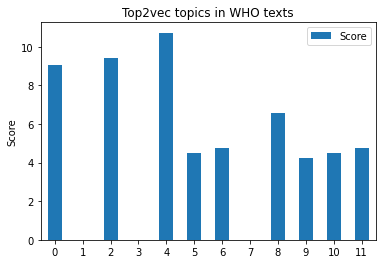

In [ ]:
ax = df_ir_topics.plot.bar(y='Score', rot=0)
ax.set_ylabel('Score')
ax.set_label('Topic')
ax.set_title('Top2vec topics in WHO texts')

In [ ]:
x = 0

for topic in topic_words_reduced:
  print(f"Topic {x}:")
  
  x+=1
  topic = topic[:20]
  t = ' '.join([str(elem) for elem in topic])
  n_docs, doc_ID, freq = words_frequency_in_documents(t)
  
  for i in range(len(topic)):
    if n_docs[i]:
      
      print(f"Term '{topic[i]}' is found in {topic[i]} number of documents with docIDs {doc_ID[i]} and frequency {freq[i]}.")
  
  print("----------------")

### Information retrieval on LDA topics

In [ ]:
df_ir_topics_lda = pd.DataFrame(columns=["Topic", "WHO_docID", "Score", "Document"])

for topic in lda_topic_list:
  t = ' '.join([str(elem) for elem in topic])
  df_score, doc_id, doc, score = retrieve_QA_from_words(t)
  print(f"The topic '{t}' was matched with document {doc_id} with score {score}:\n'{doc}'\n")
  df_ir_topics_lda = df_ir_topics_lda.append({'Topic': t, 'WHO_docID': doc_id, 'Score': score, 'Document':doc}, ignore_index=True)

display(df_ir_topics_lda)

The topic 'vaccine control world fear government order change global human people system experimental mass population mind propaganda climate push agenda passport' was matched with document 499 with score 17.882353612313956:
'who’score normative function is to compile and disseminate statistics onmortality – numbers and causes. the world expects who to provideobjective evidence on the impact of covid-19. estimatingexcess mortality associated with the covid-19 pandemic supplements the traditionaldirect measure ‘mortality directly attributable to covid-19’ with abroader measure showing the direct plus the indirect effects of thepandemic.  itis important to do this now, rather than wait, in order to underpin theneed for an equitable response during the pandemic by showing the realunderlying impact of covid-19 in different countries – especially lowerand middle income countries that may not have developed healthinformation systems to guide a targeted response. deathsdirectly attributable t

,Topic,WHO_docID,Score,Document
0,vaccine control world fear government order ch...,499,17.882354,who’score normative function is to compile and...
1,money business government make making made hea...,143,13.765360,"for most decisions, multiple ethical values an..."
2,fauci gate bill scam crime wuhan virus humanit...,477,11.116912,sars-cov-2 spreads primarily through human-to-...
3,conspiracy fact video watch doctor anti scienc...,36,13.110766,"a near-constant stream of news, sometimes cont..."
4,covid 19 vaccine agenda freedom hoax coronavir...,211,8.362336,large scale physical distancing measures and m...
5,medium people skin hand fake light pointing in...,494,11.205480,itis a regular process that who consults with ...
6,mask people stop test work lockdown wear child...,147,19.162754,disposable glovesgloves may be used by food wo...
7,pandemic world great plan planned part year re...,336,9.010466,try and reduce long periods of time spent sitt...
8,people time life year back thing long good sta...,334,17.566940,who has detailed recommendations on the amount...
9,trump state china country election biden ameri...,470,13.431620,"violence against women is highly prevalent, an..."


Text(0.5, 1.0, 'LDA topics in WHO texts')

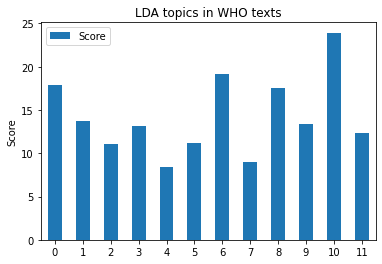

In [ ]:
ax1 = df_ir_topics_lda.plot.bar(y='Score', rot=0)
ax1.set_ylabel('Score')
ax1.set_label('Topic')
ax1.set_title('LDA topics in WHO texts')

In [ ]:
x = 0

for topic in lda_topic_list:
  print(f"Topic {x}:")
  
  x+=1
  topic = topic[:20]
  t = ' '.join([str(elem) for elem in topic])
  n_docs, doc_ID, freq = words_frequency_in_documents(t)
  
  for i in range(len(topic)):
    if n_docs[i]:
      
      print(f"Term '{topic[i]}' is found in {topic[i]} number of documents with docIDs {doc_ID[i]} and frequency {freq[i]}.")
  
  print("----------------")

Topic 0:
Term 'control' is found in control number of documents with docIDs ['20', '22', '31', '34', '51', '80', '86', '89', '90', '91', '93', '96', '102', '140', '151', '157', '176', '180', '199', '201', '202', '205', '213', '216', '227', '229', '241', '244', '246', '247', '248', '254', '308', '322', '373', '375', '377', '378', '391', '393', '427', '437', '461', '467', '513', '515', '516', '521', '526'] and frequency [1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1].
Term 'world' is found in world number of documents with docIDs ['5', '14', '16', '26', '34', '36', '39', '84', '86', '87', '115', '129', '156', '180', '211', '213', '261', '264', '276', '290', '322', '332', '385', '396', '399', '400', '406', '417', '423', '424', '432', '439', '444', '461', '471', '477', '478', '499', '500', '501', '515', '516', '519', '520', '521', '523'] and frequency [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 